# Example: 1D GLE Dynamics and Memory Kernel Extraction

In this notebook I demonstrate how to run a very simple 1D generalized Langevin dynamics simulation using the in-house MD integrator of glepy. Subsequently, I demosntrate how to calculate the memory/friction kernel from the MD and show that it is consistent with the input. 


# Running GLE dynamics

We begin by setting up and running GLE dynamics using 1D system with a harmonic potential and a simple damped-exponential memory kernel:

$$K(t) = C e^{-\gamma t} \cos(\omega t) = -\mathbf{A}_{vs} e^{-\mathbf{A}_{s}t} \mathbf{A}_{sv} $$

The memory kernel is related to the parameters of the Ornstein-Uhlenbeck $\mathbf{A}$ matrices by:

$$
A_{vs} =
\begin{pmatrix}
    \sqrt{C/2} & \sqrt{C/2}
\end{pmatrix}
$$

$$
A_{sv} =
\begin{pmatrix}
    \sqrt{C/2} \\
    \sqrt{C/2}
\end{pmatrix}
$$

$$
A_{s} =
\begin{pmatrix}
    2 \gamma & \sqrt{\omega^2+\gamma^2} \\
    -\sqrt{\omega^2+\gamma^2} & 0
\end{pmatrix}
$$

These matrices are the input we provide the GLE integrator. For more details on the derivation of these matrices see the following paper: 

Ceriotti, M.; Bussi, G.; Parrinello, M. Langevin Equation with Colored Noise for Constant-Temperature Molecular Dynamics Simulations. Phys. Rev. Lett. 2009, 102 (2), 020601. https://doi.org/10.1103/PhysRevLett.102.020601.


In [1]:
##### Import dependencies and set up simulation parameters

import numpy as np
import matplotlib.pyplot as plt

from glepy.memory import time as memt
import glepy.md.dynamics as md
import glepy.md.forcefield as FFgen

plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] =  22
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 28
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['text.usetex'] = True

# System parameters
nsys = 10           # number of system degrees of freedom
ndim = 1            # dimension of system
m = 195.084         # mass of system particles

# Forcefield parameters
frc_k = 30000              # harmonic force constant
x0 = np.zeros((nsys,ndim)) # equilibrium position of harmonic potential

# Bath Arguments
temp        = 2.4943  # Temperature
md.kb       = 1       # Boltzmann constant

# Ornstein-Uhlenbeck parameter matrices
Amat = np.array([
[0.0, -10.0, -10.0],
[10.0, 0.5, 5],
[10.0, -5, 0.0]
])
As  = Amat[1:,1:]
Bs  = np.sqrt(md.kb * temp * (As + As.T))
Asv = Amat[1:,0:1]
Avs = Amat[0:1,1:]

# Simulation parameters
eq_steps    = 20000    # Equilibriation Steps
run_steps   = 500000   # Production Steps
dt          = 0.001
stride      = 5

In [2]:
##### Set up Forcefield and simulations objects

# Create Forcefield
ff = FFgen.ff_harm(nsys, ndim, frc_k, x0)

# Set initial conditions according to averages @ thermal equilibrium  
pos0 = np.random.normal(loc=x0,  scale = np.sqrt((md.kb*temp)/frc_k), size=(nsys,ndim))
vel0 = np.random.normal(loc=0.0, scale = np.sqrt(md.kb*temp/m), size=(nsys,ndim))

# Create system and integrator objects
system = md.System(m,nsys=nsys,ndim=ndim,box_dim=1000)
system.pos = pos0
system.vel = vel0

integrator = md.GLD(system, ff, dt, temp, As, Avs, Asv, Bs, PBC=False)

print("Running Equilibriation")
integrator.run( int(eq_steps) )

print("Running Dynamics")
report1 = md.reporter_PosVelAccFrc()
report2 = md.reporter_Temp(kb=md.kb, m=m, ndim=1)
integrator.reporters = [report1,report2]
integrator.reportints = [stride,10]
integrator.run( int(run_steps) )

pos,vel,acc,frc = report1.output()
temp_sim = report2.output()
print("Done")

Running Equilibriation
Running Dynamics
Done


# Extract memory kernel

Now that we have run the dynamics, we wish to use an algorithm to extract/compute the memory kernel and compare to the original results. The particle in our simulation obeys:
$$ m \ddot{x}(t) = -\frac{d W}{dx}(t) - \int_0^t K(t-\tau) \dot{x}(\tau) d\tau + R(t) $$

where $W(x)$ is the potential of mean force and $K(t)$ is the memory/friciton kernel and $R(t)$ is the colored (Ornstein-Uhlenbeck) noise. If multiply both sides by $\dot{x}(0)$ and take the equilibrium average:

$$ \left \langle \left[m \ddot{x}(t) + \frac{d W}{dx}(t) \right]  \dot{x}(0) \right \rangle = - \int_0^t K(t-\tau) \left \langle \dot{x}(\tau) \dot{x}(0) \right \rangle d\tau $$ 

Which we can simplify to:

$$ C_f(t) = - \int_0^t K(t-\tau) C_v(\tau) d\tau $$

where $C_f$ is a force-velocity correlation function and $C_v$ is the velocity-velocity autocorrelaiton function. This Volterra equation may either be solved by using the FFT along with the convolution theorem or by choosing a particular time-quadrature for the convolution integral through which the equation can be solved iteratively. We will explore both options below:

In [3]:
pos,vel,acc,frc = report1.output()

# Calculate temperature from MD samples
kbT = m/ndim * np.sum( np.mean( vel**2, axis=1), axis=1).mean()
print("Temp = %4.4f kJ/mol = %4.4f Kelvin"%(kbT, 120.2731 * kbT))

# Calculate Force Constants
pos_mean = np.mean(pos)
print("Mean Position: ",pos_mean)

frck_md = ( kbT / np.var(pos,axis=0) ).mean()
print("Spring Constant calc %0.2f, input %0.2f (kJ/mol/Ang^2)\n"%(frck_md/100,frc_k/100))

# Derivative of potential fo Mean Force (coarse-grained force)
dpmf_func = FFgen.ff_harm(nsys, ndim, frck_md, pos_mean)
dpmf = dpmf_func.calc_frc(pos)

# Reshape arrays
pos = pos.reshape(-1,nsys*ndim)
vel = vel.reshape(-1,nsys*ndim)
frc = frc.reshape(-1,nsys*ndim)
acc = acc.reshape(-1,nsys*ndim)
dpmf = dpmf.reshape(-1,nsys*ndim)

# Time-axis
tcorr = 2000 # number of timesteps to use to compute memory kernel
tarr = np.arange(tcorr)*dt*stride # time array
tarr_mid = (tarr[1:]+tarr[0:-1])/2.0

# Calculate Correlation Functions
print("calculating velocity tcfs")
vel_tcf  = memt.calc_tcf(vel, vel, max_t=tcorr, mode="scipy").mean(axis=1)
dvel_tcf = -memt.calc_tcf(vel, acc, max_t=tcorr, mode="scipy").mean(axis=1)

print("calculating force tcfs")
frc_tcf      =  memt.calc_tcf(acc - dpmf/m, vel, max_t=tcorr, mode="scipy").mean(axis=1)
dfrc_tcf     = -memt.calc_tcf(acc - dpmf/m, acc, max_t=tcorr, mode="scipy").mean(axis=1)

# Memory Kernels - Different Methods
print("calculating memory kernels")
Ktrap = memt.calc_memory_dtrapz(dvel_tcf, dfrc_tcf, vel_tcf[0], dt*stride)
Kmid = memt.calc_memory_midpt(vel_tcf, frc_tcf, dt*stride)
Kfft = memt.calc_memory_fft(vel_tcf, frc_tcf, dt*stride)

# True Memory Kernel
Kt_inp = -Avs @  memt.matrixexp(-As,tarr, Hermitian=False) @ Asv
Kt_inp = Kt_inp[:,0,0]
print("Done")

Temp = 2.7221 kJ/mol = 327.3984 Kelvin
Mean Position:  -3.008853604272887e-05
Spring Constant calc 308.45, input 300.00 (kJ/mol/Ang^2)

calculating velocity tcfs
calculating force tcfs
calculating memory kernels
Done


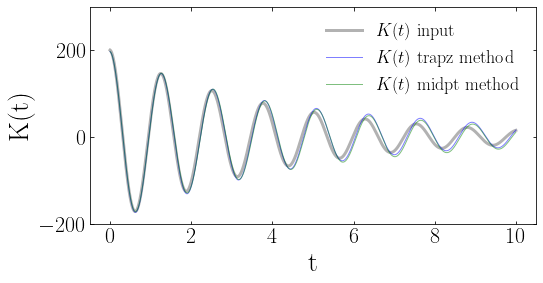

In [5]:
# Plot
plt.figure(figsize=[8,4])
plt.plot(tarr, np.real(Kt_inp), color="k", linewidth=3.0, alpha=0.3, label=r"$K(t)$ input")
plt.plot(tarr, Ktrap,  color="b", linewidth=1.0, alpha=0.5, label=r"$K(t)$ trapz method")
plt.plot(tarr_mid, Kmid, color="g", linewidth=1.0, alpha=0.5, label=r"$K(t)$ midpt method")
#plt.plot(tarr[1:],np.real(Kfft[1:]), color="r", linewidth=1.0, alpha=0.5, label=r"$K(t)$ fft method")
plt.ylabel("K(t)")
plt.xlabel("t")
plt.legend(frameon=False)
plt.ylim(-200,300)
plt.savefig("./memory.png",dpi=300,bbox_inches="tight")

# 3: Conclusions

We see that the trapezoidal and midpoint quadrature solutions to the Volterra equation are much more numerically accurate than the FFT method. 

In general, small errors in the potential of mean force lead to large errors in the memory kernel when using the FFT method.
This is due to the step where we take a ratio between two functions in frequency space. 